
### VQE custom implementation


In [10]:
from math import pi
from typing import Dict, Any

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.providers.aer import AerSimulator

from qiskit.visualization import plot_histogram

from src.utils.ising import IsingModel
from src.utils.vqe import create_circ, qc_eval, obj_func

In [ ]:
# Use Aer's qasm_simulator
simulator_method = 'automatic'
simulator = AerSimulator()
# define circuit params 
num_qubits = 4
circ_depth = 1
# number circuit evaluations
shots = 64
num_param = num_qubits * (circ_depth + 1)

# define initial point
rng = np.random.default_rng(seed=42)
thetas0 = rng.random(num_param) * pi #np.zeros((circ_depth + 1, num_param // (circ_depth + 1)))
# define specific optimizer
method = 'COBYLA'
# set maximum optimizer steps
maxiter = 10
# alpha-th quantile to evaluate the loss
alpha = 25

In [ ]:
# define a ferro ising model
# with uniform external field
J=1
h=0.05*J

# hamiltonian is defined with +
# following http://spinglass.uni-bonn.de/ notation 
adja_dict = {}
field = np.zeros(num_qubits)
ext_field = h
for i in range(num_qubits):
    field[i] = ext_field
    if i == num_qubits - 1:
        continue
    adja_dict[(i, i+1)] = -J
# class devoted to set the couplings and get the energy 
ising = IsingModel(num_qubits, dim=1, adja_dict=adja_dict, ext_field=field)
print(ising.AdjaDict, ising.ExtField)

In [ ]:
qc = create_circ(thetas0, num_qubits, circ_depth)
# Draw the circuit
qc.draw()

In [ ]:
counts = qc_eval(qc, simulator, shots)
plot_histogram(counts)

In [ ]:
# test objective function
loss0 = obj_func(thetas0, simulator, num_qubits, circ_depth, shots, ising, alpha=alpha, verbose=True)
print(f"\nLoss at step 0 -> {loss0}")

In [ ]:
res = minimize(obj_func, thetas0, args=(simulator, num_qubits, circ_depth, shots, ising, alpha, True), 
               method=method, options={'maxiter': maxiter, 'disp':True})

In [ ]:
thetas_opt  = res.x
qc = create_circ(thetas_opt, num_qubits, circ_depth)
counts = qc_eval(qc, simulator, shots)
plot_histogram(counts)

ridefinire time to solution
in lidar loro trovano l'ottimo per ogni N numero di istanze parallele
carleo non-stoquastic QA con troyer

Noi geralizziamo facendo una funzione in 2D oppure numero di shots come parametro t in modo fa fare una famiglia di funzioni

Cosa vogliamo: resolurce to solution, moltiplico N_shot e N_step
ferromagnetico bias
mi servono alcuni for
- random su theta
- scalo su shots 
- scalo su step (maxiter)

alpha suggerito da loro (0.25)

valuto con RTS (TTS dove moltiplico per gli shots) non normalizzato per n_max

n.b. green quantum computing paper montangero

In [77]:
import os
import json

dir_path = "results/n4/"

p_succ = []
sigma_p = []
for filename in os.listdir(dir_path):
    filename = dir_path + filename
    with open(filename, "r") as file:
        data = json.load(file)
    succ = []
    for run in data:
        succ.append(run["global_min"])
    p_succ.append(np.asarray(succ).mean())
    sigma_p.append(np.asarray(succ).reshape(5,-1).mean(0).std(ddof=1) / np.sqrt(20)) 

In [78]:
p_succ = np.asarray(p_succ).reshape((-1,5))
sigma_p = np.asarray(sigma_p).reshape((-1,5))

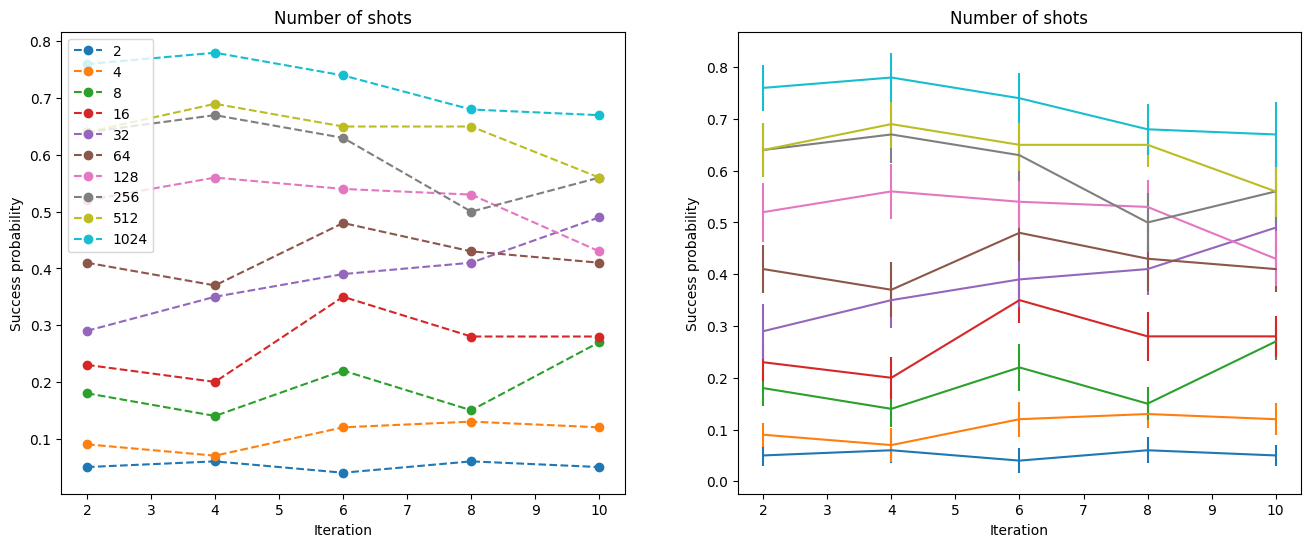

In [89]:
legend = ["2", "4", "8", "16", "32", "64", "128", "256", "512", "1024"] 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

for i, d in enumerate(p_succ):
    ax1.plot(np.arange(2,12,2), d, '--o', label=legend[i])
    ax2.errorbar(np.arange(2,12,2), d, yerr=sigma_p[i,:], label=legend[i])

ax1.set_title('Number of shots')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Success probability')

ax2.set_title('Number of shots')

ax2.set_xlabel('Iteration')
ax2.set_ylabel('Success probability')

ax1.legend()

plt.savefig("iter_prob.png")

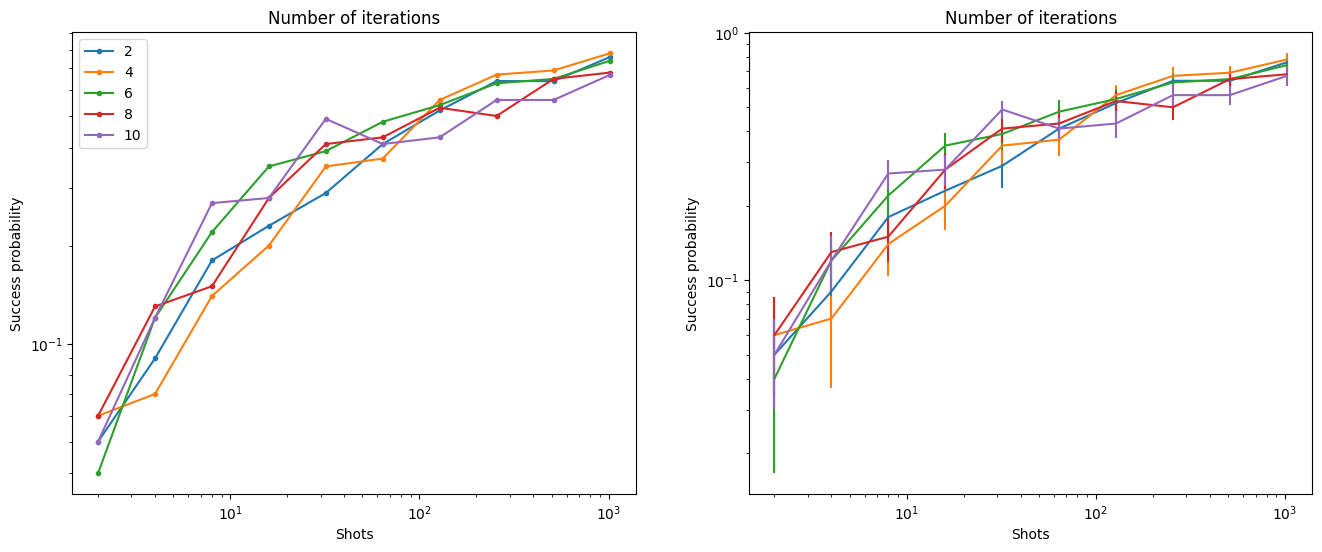

In [90]:
legend = ["2", "4", "6", "8", "10"] 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

for i, d in enumerate(p_succ.T):
    ax1.plot(2**np.arange(1,11), d, '.-', label=legend[i])
    ax2.errorbar(2**np.arange(1,11), d, yerr=sigma_p[:,i], label=legend[i])

ax1.loglog()
ax2.loglog()

ax1.set_title('Number of iterations')
ax2.set_title('Number of iterations')

ax1.set_xlabel('Shots')
ax1.set_ylabel('Success probability')
ax1.legend()

ax2.set_xlabel('Shots')
ax2.set_ylabel('Success probability')

plt.savefig("shot_prob.png")